## Forward Inference

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import statsmodels.formula.api as smf

In [14]:
df = pd.read_csv('cleaned_data.csv')

In [16]:
X = df[[ 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes',
       'actor_1_facebook_likes', 'gross', 'cast_total_facebook_likes',
       'facenumber_in_poster', 'budget', 'title_year', 'actor_2_facebook_likes',
       'imdb_score', 'aspect_ratio', 'movie_facebook_likes', 'profit']]

In [21]:
# Split the data into training and testing sets
train_data, test_data = train_test_split(X, test_size=0.2, random_state=42)

# Save the training and testing data as CSV files
train_data.to_csv('train_X.csv', index=False)
test_data.to_csv('test_X.csv', index=False)

In [22]:
train_X = pd.read_csv('train_X.csv')
test_X = pd.read_csv('test_X.csv')


In [27]:
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.ols('profit~' + '+'.join(predictor_subset),data = train_X).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}

In [18]:
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [19]:
def forward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [28]:
models_best = forward_selection()

Processed  14 models on 1 predictors in 0.1953129768371582 seconds.
Processed  13 models on 2 predictors in 0.13944125175476074 seconds.
Processed  12 models on 3 predictors in 0.11410760879516602 seconds.
Processed  11 models on 4 predictors in 0.1750490665435791 seconds.
Processed  10 models on 5 predictors in 0.17993807792663574 seconds.
Processed  9 models on 6 predictors in 0.19754981994628906 seconds.
Processed  8 models on 7 predictors in 0.27509307861328125 seconds.
Processed  7 models on 8 predictors in 0.2411031723022461 seconds.
Processed  6 models on 9 predictors in 0.18419289588928223 seconds.
Processed  5 models on 10 predictors in 0.1787710189819336 seconds.
Processed  4 models on 11 predictors in 0.1158287525177002 seconds.
Processed  3 models on 12 predictors in 0.08898806571960449 seconds.
Processed  2 models on 13 predictors in 0.08885407447814941 seconds.
Processed  1 models on 14 predictors in 0.03239703178405762 seconds.
Total elapsed time: 2.2753329277038574 seco

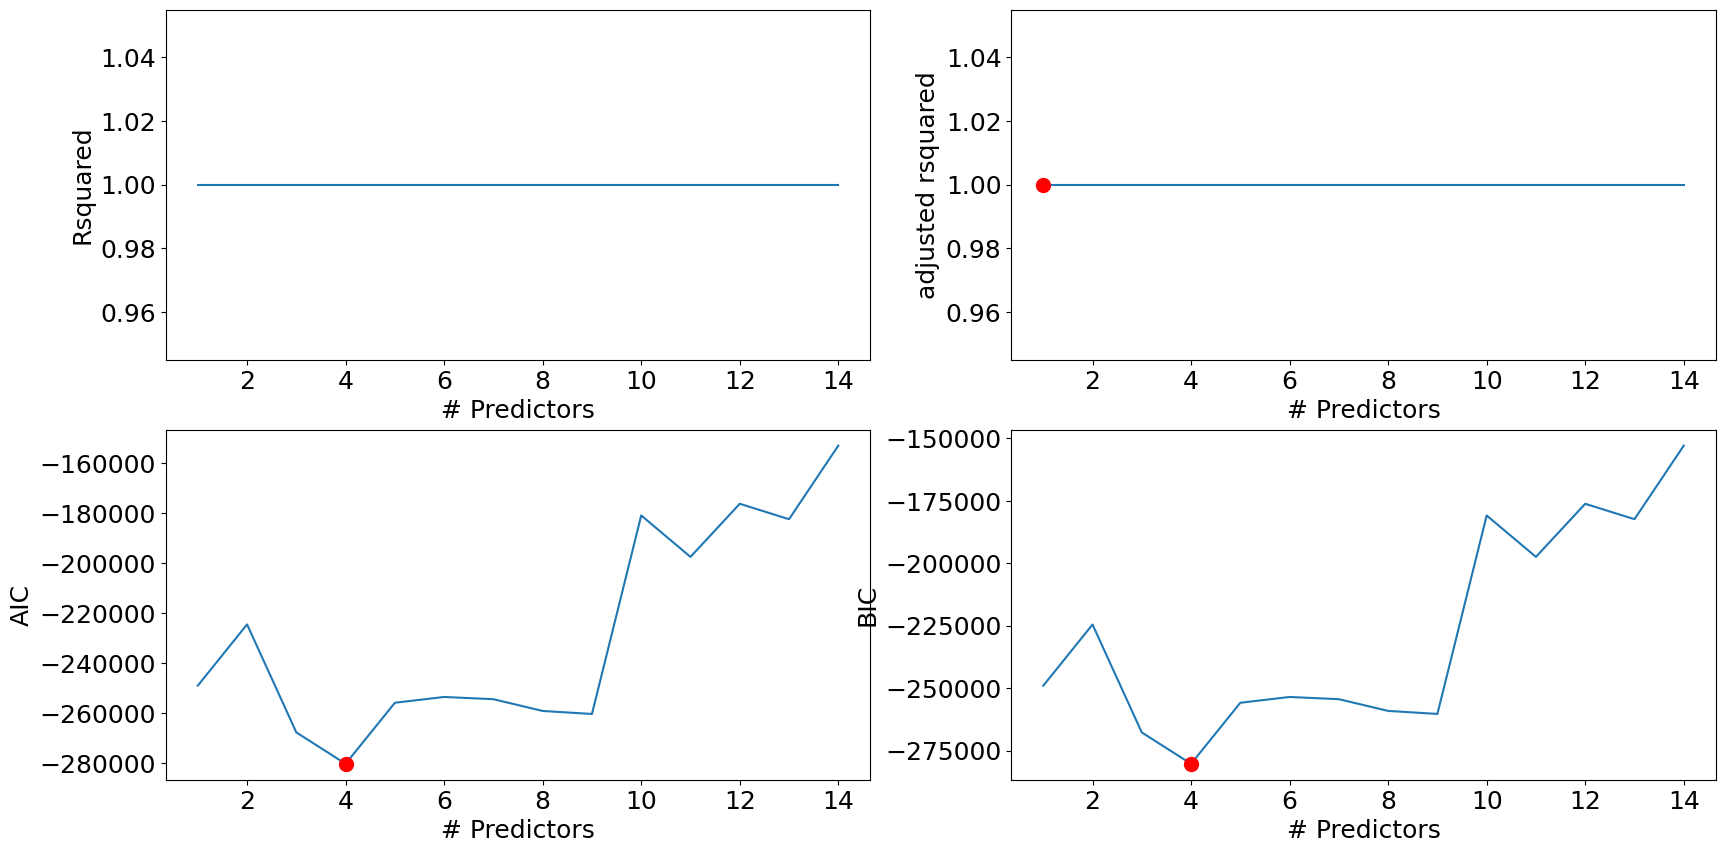

In [30]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
best_sub_plots()

The model with 4 predictors is the best model, according to AIC and BIC.

In [33]:
best_fwd_reg_model = models_best.loc[4,'model']
models_best.loc[4,'model'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 8.499e+34
Date:                Sun, 05 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:46:20   Log-Likelihood:             1.4016e+05
No. Observations:                8989   AIC:                        -2.803e+05
Df Residuals:                    8984   BIC:                        -2.803e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                1.261e-08   2.14e-09      5.883      0.000    8.41e-09    1.68e-08
profit                      1.0000   1.72e-18   5.82e+17      0.000       1.000       1.000
duration                -4.805e-11   1.93e-11     -2.494      0.013   -8.58e-11   -1.03e-11
director_facebook_likes -3.199e-12   1.44e-13    -22.270      0.000   -3.48e-12   -2.92e-12
actor_3_facebook_likes   7.093e-13   2.21e-13      3.214      0.001    2.77e-13    1.14e-12
==============================================================================
Omnibus:                    24834.899   Durbin-Watson:                   1.980
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        957481281.263
Skew:                         -35.048   Prob(JB):                         0.00
Kurtosis:                    1600.340   Cond. No.                     1.25e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [35]:
#Finding the RMSE of the model selected using the forward selection procedure, where the predictors
#include 2-factor interactions
pred_profit = np.exp(best_fwd_reg_model.predict(test_X))
np.sqrt(((pred_profit - test_X.profit)**2).mean())

c:\Users\Yasmeen\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


inf

Backward Stepwise Selection

In [36]:
def backward(predictors):
    
    tic = time.time()
    
    results = []
    
    for combo in itertools.combinations(predictors, len(predictors)-1):
        results.append(processSubset(combo))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)-1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model

In [39]:
def backward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"], index = range(1,len(X.columns)))

    tic = time.time()
    predictors = X.columns
    models_best.loc[len(predictors)] = processSubset(predictors)
    
    while(len(predictors) > 1):  
        models_best.loc[len(predictors)-1] = backward(predictors)
        predictors = models_best.loc[len(predictors)-1]["model"].params.index[1:]

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best

In [40]:
models_best = backward_selection()

Processed  14 models on 13 predictors in 0.6381967067718506 seconds.
Processed  13 models on 12 predictors in 0.4716205596923828 seconds.
Processed  12 models on 11 predictors in 0.48184728622436523 seconds.
Processed  11 models on 10 predictors in 0.37268638610839844 seconds.
Processed  10 models on 9 predictors in 0.3169081211090088 seconds.
Processed  9 models on 8 predictors in 0.26355671882629395 seconds.
Processed  8 models on 7 predictors in 0.199554443359375 seconds.
Processed  7 models on 6 predictors in 0.1745283603668213 seconds.
Processed  6 models on 5 predictors in 0.13725590705871582 seconds.
Processed  5 models on 4 predictors in 0.11357378959655762 seconds.
Processed  4 models on 3 predictors in 0.06403851509094238 seconds.
Processed  3 models on 2 predictors in 0.04394364356994629 seconds.
Processed  2 models on 1 predictors in 0.026508331298828125 seconds.
Total elapsed time: 3.539407968521118 seconds.


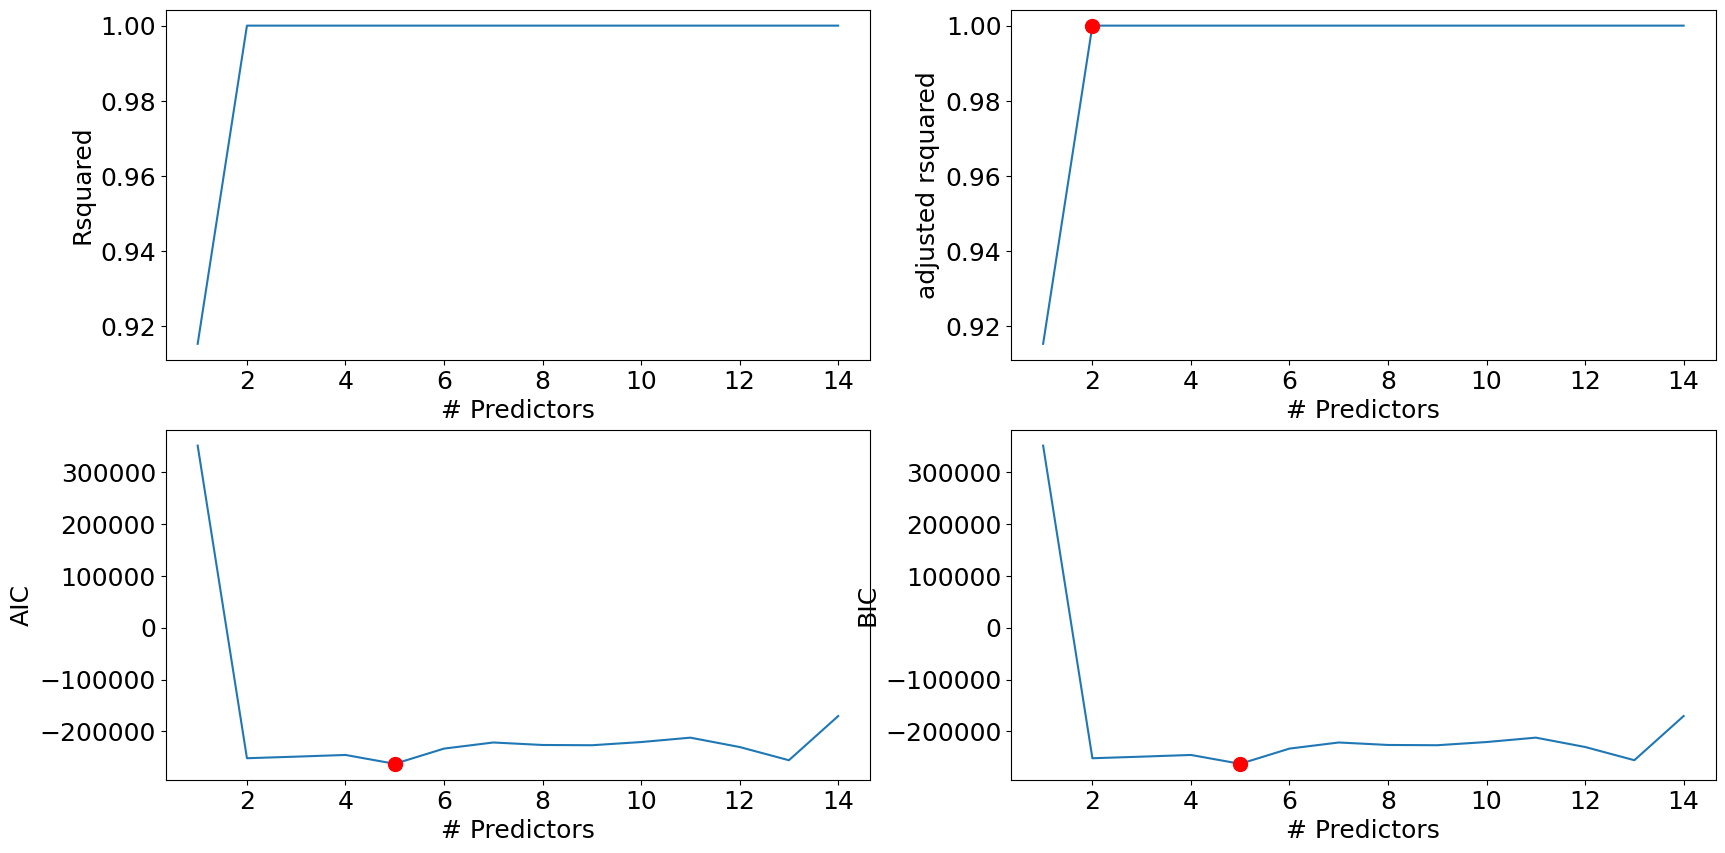

In [41]:
best_sub_plots()

In [42]:
best_bwd_reg_model = models_best['model'][5]
best_bwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 profit   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.485e+33
Date:                Sun, 05 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:48:35   Log-Likelihood:             1.3130e+05
No. Observations:                8989   AIC:                        -2.626e+05
Df Residuals:                    8983   BIC:                        -2.626e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                2.512e-08   5.75e-09      4.372      0.000    1.39e-08    3.64e-08
duration                  1.43e-10   5.25e-11      2.724      0.006    4.01e-11    2.46e-10
director_facebook_likes -1.476e-11   3.85e-13    -38.290      0.000   -1.55e-11    -1.4e-11
actor_3_facebook_likes  -6.108e-12   6.12e-13     -9.976      0.000   -7.31e-12   -4.91e-12
gross                       1.0000   1.69e-17   5.93e+16      0.000       1.000       1.000
budget                     -1.0000   4.69e-18  -2.13e+17      0.000      -1.000      -1.000
==============================================================================
Omnibus:                     5343.065   Durbin-Watson:                   1.754
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            54787.535
Skew:                           2.733   Prob(JB):                         0.00
Kurtosis:                      13.789   Cond. No.                     1.26e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
#Finding the RMSE of the model selected using the backward selection procedure, where the predictors
#include 2-factor interactions
pred_profit = np.exp(best_bwd_reg_model.predict(test_X))
np.sqrt(((pred_profit - test_X.profit)**2).mean())

c:\Users\Yasmeen\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


inf